# Machinaal Leren - Sprint 3: Multiple data sources

## Task:
Use the images or external data sources (eg. Ghent open data)

Possible tasks:
* Use the images to find similar listings (e.g. similar interior style)
* Cluster the images
* Automatically detect attributes of the listing (e.g. garden, bath, shower, washing machine, ...) based on the images
* Find duplicate listings based on the images
* Detect anomalies (rooms that look very different)
* Predict which room a picture is taken in (bedroom, bathroom, outside, ...)
* Combine with external data to better predict the price (e.g. location of public transport, proximity to attractions, ...)
* ...

## Work table

|Task|Peter Bonnarens|Philip Kukoba|Lennert Franssens|
|------|------|------|------|
|1. Loading and cleaning dataset  | X |  |  |
|2. Find similar listings  | X |  |   |
|3. Find duplicate listings  | X |  |   |
|4. Cluster the images  |   |   |  |
|5. Detect attributes of the listing  |   |   |  |
|6. Detect anomalies  |   |   |  |
|7. Predict which room a picture is taken in  |   |   |  |
|8. Use external data to better predict the price  |   |   |  |
|9. Extra 1  |  X |   |  |
|10. Extra 2  |   |   |  |
|11. Extra 3  |   |   |  |

# **1 - LOADING AND CLEANING THE DATASET**

## Import packages and read dataset
Here we import the needed packages for this project and read the 'listings' dataset.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import random
from scipy.spatial import distance
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
from sklearn.decomposition import PCA
from keras.models import Model

pd.set_option('display.max_rows', 500)

# remove warnings from output
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# matplotplib figure size in inches
plt.rcParams['figure.figsize'] = 15,12

# reading the dataset and making a pandas dataframe
listings = pd.read_csv("data/listings.csv")

## Cleaning the 'listings' dataset

TODO: write text

In [2]:
# TODO: clean the listings dataset

# **2 - FINDING SIMILAR LISTINGS BASED ON THE IMAGES**

To find listings that are similar, we use what is called **content-based image retrieval** (**CBIR**). This is the same principle that is used in search engines, a certain image is given and the engine will retrieve similar images. For this task, features will need to be extracted from all images so that we can compare them. Instead of writing our own model, we use a smart approach that is described in the following notebook: https://github.com/ml4a/ml4a/blob/master/examples/info_retrieval/image-search.ipynb.

First, we will load a pre-trained neural network from Keras: `VGG16`. This is a convolutional neural network model that is specifically made for image classification. It contains 16 layers, has an accuracy rate of 92.7% and was trained for weeks. The architecture is shown below.

![VGG16 architecture](vgg16_architecture.jpeg "VGG16 architecture")

Now we load the model, we will use the pre-trained weights from `ImageNet` and include the 3 fully-connected layers at the top of the network.

In [3]:
model = VGG16(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Now we have a highly effective image classifier trained on the `ImageNet` database. The problem is that we are not interested in classifying our images, but rather comparing them based on features to detect similarities. We expect that this classifier must form a very effective representation of an image in order to be able to classify it with such high accuracy. We can use this to our advantage by dropping the last dense layer (the `predictions` layer) where the actual classification is happening, and keep the rest of the network. This way, we actually have a highly efficient feature extractor (`feat_extractor`).

In [4]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In order to to test our feature extractor, we first define a helper function to load and pre-process an image from a specified path. Our `VGG16` model expects an input vector of the correct dimensions, namely a color image of size 224x224. To do the pre-processing, `Keras` has a built-in function called `preprocess_input`.

In [5]:
def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Now we will load a chosen image, perform the prediction of our `feat_extractor` and plot the output.

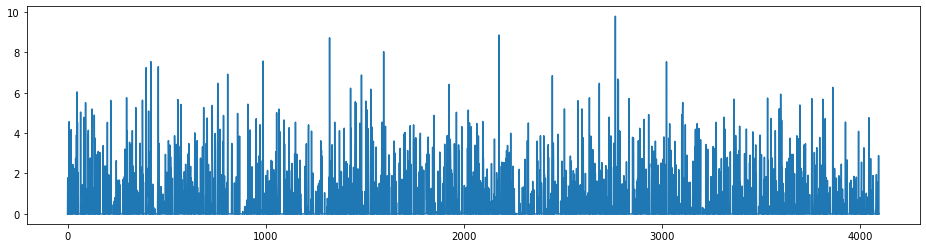

In [6]:
img, x = load_image("./data/images/187870/0.jpg")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

The `predict` function return an array with one element per image. Each element containes a 4096-element array, which is the activations of the last fully-connected layer `fc2`. Our expectation is that these activations form a good representation of the image, such that similar images would produce similar activations.

Next we walk through our image directory and only keep the paths to the images that have a `.jpg` extension. 

In [7]:
images_path = "./data/images"
image_extensions = ['.jpg']

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
print("keeping %d images to analyze" % len(images))

keeping 9388 images to analyze


In the next cell we start a loop that will open each image, extract its feature vector, and append it to a list called `features` which will contain our activations for each image. Because this process takes a long time to finish, we only ran this code once and saved the features as a numpy array into the file `features.npy`. When we want to use these features in our program, we just load the numpy array from that file.

In [8]:
# Warning: takes a long time to run! 

# tic = time.process_time()

# features = []
# for i, image_path in enumerate(images):
#     if i % 500 == 0:
#         toc = time.process_time()
#         elap = toc-tic
#         print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
#         tic = time.process_time()
#     img, x = load_image(image_path)
#     feat = feat_extractor.predict(x)[0]
#     features.append(feat)

# print('finished extracting features for %d images' % len(images))
# np.save('features.npy', features)

To remove redundancy in the 4096-bit feature vectors and reduce the dimensionality, we use **principal component analysis (PCA)** (link: https://en.wikipedia.org/wiki/Principal_component_analysis). This will not only remove possible skew that would occur in our similarity comparisons towards over-represented features, but also speed up our computation time since our feature vectors will have a much smaller length. Here we chose to keep 300 principal components, but this number can be tweaked.

In [9]:
features = np.load("features.npy")
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)


Now we define 2 more helper functions: 

`get_closest_images` which calculates the cosine distance between the pca_features of our query image and the pca_features of every other image we have, and then orders them so we keep to `num_results` images with the closest cosine distance (or thus the most similar images).

`get_concatenated_images` which helps us load those similar images and append them to `concat_image` so we can display them in a row using matplotlib.

In [10]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

At last, we try out our model by choosing a random query image, getting the most similar images to it and displaying all of them so we can visually compare if our model does its job.

Text(0.5, 1.0, 'result images')

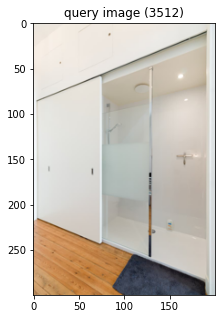

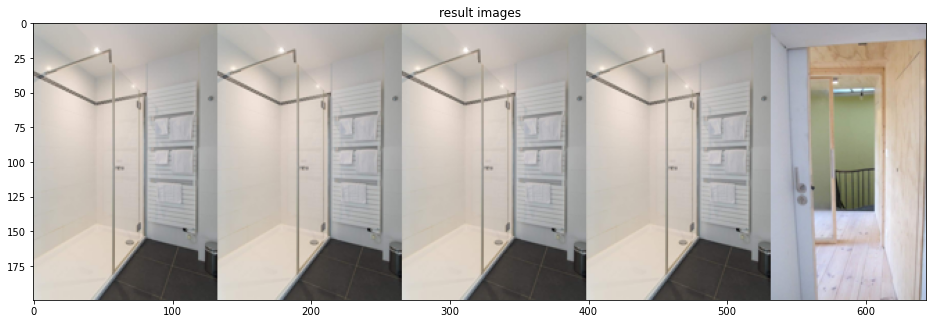

In [19]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

# **3 - FINDING DUPLICATE LISTINGS BASED ON THE IMAGES**

# **4 - CLUSTERING THE IMAGES**

# **5 - AUTOMATICALLY DETECT ATTRIBUTES OF LISTINGS BASED ON THE IMAGES**

# **6 - DETECTING ANOMALIES BASED ON THE IMAGES**

# **7 - PREDICTING WHICH ROOM A PICTURE IS TAKEN IN**

# **8 - USING EXTERNAL DATA TO BETTER PREDICT THE PRICE**

# **9 - EXTRA 1**

# **10 - EXTRA 2**

# **11 - EXTRA 3**